In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import configparser
import os
from pathlib import Path

import aps
import aps.ai.autoalignment.beamline28IDB.optimization.analysis_utils as analysis
import aps.ai.autoalignment.beamline28IDB.optimization.common as opt_common
import joblib
import matplotlib.pyplot as plt
import numpy as np
import optuna
import scipy
from epics import ca
from IPython.display import Image, display_png
import cmasher as cmm

import aps.ai.autoalignment.beamline28IDB.optimization.analysis_plot_utils as apu
ca.finalize_libca()

%matplotlib inline

28-ID - VKB Pitch Motor Resolution: 2e-05 deg


**** The executable "caRepeater" couldn't be located
**** because of errno = "No such file or directory".
**** You may need to modify your PATH environment variable.
**** Unable to start "CA Repeater" process.


In [3]:
mpl.rcParams.update({"font.size": 12, "text.usetex": False, "svg.fonttype": "none"})

In [4]:
exp_type = "centroid_fwhm"

In [5]:
apu.PARETO_PLOT_ORDER = {"Centroid": 0, "FWHM":1} 

In [6]:
# base_dir = Path(aps.__file__).parents[1]
# autoalign_dir = base_dir / f'work_directory/28-ID/AI/autoalignment/'
autoalign_dir = Path("/Users/skandel/Library/CloudStorage/Box-Box/Beamtime_28ID_Nov2022/AI/autofocusing/")
data_base_dir = autoalign_dir / exp_type
print(f"data base dir exists {data_base_dir.exists()}")

data base dir exists True


In [7]:
!ls {data_base_dir}

centroid_fwhm_150_2022-11-18_images
centroid_fwhm_150_2022-11-18_steps
centroid_fwhm_75_2022-11-17.png
centroid_fwhm_autofocusing.ini
centroid_fwhm_optimization_final_150_2022-11-18_13:00.pkl
centroid_fwhm_optimization_final_75_2022-11-17_16:00.pkl
final_setup_2022-11-18.png
initial_setup_2022_11_18.png


### peak_fwhm_150_2022-11-21

In [8]:
!ls {data_base_dir}

centroid_fwhm_150_2022-11-18_images
centroid_fwhm_150_2022-11-18_steps
centroid_fwhm_75_2022-11-17.png
centroid_fwhm_autofocusing.ini
centroid_fwhm_optimization_final_150_2022-11-18_13:00.pkl
centroid_fwhm_optimization_final_75_2022-11-17_16:00.pkl
final_setup_2022-11-18.png
initial_setup_2022_11_18.png


In [9]:
log_file = Path(data_base_dir / "centroid_fwhm_optimization_final_150_2022-11-18_13:00.pkl")
log_file.exists()

True

In [10]:
hist_dir = Path(data_base_dir / "centroid_fwhm_150_2022-11-18_steps")
hist_dir.exists()

True

In [11]:
base_out_dir = Path("/Users/skandel/Library/CloudStorage/Box-Box/autofocus_paper/figures/centroid_fwhm")
base_out_dir.mkdir(exist_ok=True)

In [12]:
out_dir = base_out_dir
out_dir.mkdir(exist_ok=True)

In [13]:
study = analysis.create_study_from_trials(log_file, n_objectives=2)

[I 2023-08-06 22:15:22,818] A new study created in memory with name: no-name-e0fcb304-cb13-45c8-8232-2038534d9d25


Assuming minimization for all objectives.


In [14]:
n_steps = len(study.trials)

In [15]:
hists = analysis.load_histograms_from_files(n_steps, hist_dir, extension="pkl")

In [16]:
study.trials[0].user_attrs["dw"]._DictionaryWrapper__dictionary

{'h_sigma': 0.390024449573547,
 'h_fwhm': 0.036416859657251166,
 'h_centroid': -0.0036781130971529352,
 'h_peak': -0.05430013895321907,
 'v_sigma': 0.45698579053964605,
 'v_fwhm': 0.01495584212583112,
 'v_centroid': 0.00470905253851156,
 'v_peak': 0.013980461117623974,
 'integral_intensity': 285.98098396737913,
 'peak_intensity': 40755.0,
 'gaussian_fit': {}}

In [17]:
dwds = [dict(**t.user_attrs["dw"]._DictionaryWrapper__dictionary) for t in study.trials]

Trial values: centroid 5.975e-03 fwhm 3.937e-02
Trial dw:
{'_DictionaryWrapper__dictionary': {'h_sigma': 0.390024449573547, 'h_fwhm': 0.036416859657251166, 'h_centroid': -0.0036781130971529352, 'h_peak': -0.05430013895321907, 'v_sigma': 0.45698579053964605, 'v_fwhm': 0.01495584212583112, 'v_centroid': 0.00470905253851156, 'v_peak': 0.013980461117623974, 'integral_intensity': 285.98098396737913, 'peak_intensity': 40755.0, 'gaussian_fit': {}}}
Trial mots
dict_items([('hb_1', 0.0), ('hb_2', 0.0), ('hb_pitch', 0.0), ('hb_trans', 0.0), ('vb_bender', 0.0), ('vb_pitch', 0.0), ('vb_trans', 0.0)])


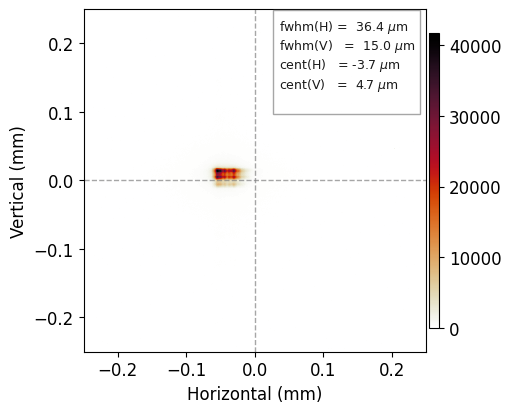

In [18]:
print(
    f"Trial values: centroid {study.trials[0].values[0]:4.3e} fwhm {study.trials[0].values[1]:4.3e}"
)
print("Trial dw:")
print(study.trials[0].user_attrs["dw"].__dict__)

dwd = dict(**study.trials[0].user_attrs["dw"]._DictionaryWrapper__dictionary)

print('Trial mots')
print(study.trials[0].params.items())


plt.figure(figsize=[5, 5], constrained_layout=True)
plt.pcolormesh(
    hists[0].hh,
    hists[0].vv,
    hists[0].data_2D.T[::-1],
    cmap=apu.CMAP,
    #norm=mpl.colors.LogNorm(100, max_count),
    rasterized=True,
)
plt.xlim(-0.25, 0.25)
plt.ylim(-0.25, 0.25)
plt.axhline(0, color="gray", ls="--", linewidth=1, alpha=0.7)
plt.axvline(0, color="gray", ls="--", linewidth=1, alpha=0.7)
plt.xlabel("Horizontal (mm)")
plt.ylabel("Vertical (mm)")
# plt.title("Initial")
plt.colorbar(pad=0.01, aspect=30, shrink=0.6)

ax = plt.gca()
ax.set_aspect("equal")

text = (
    rf"{'fwhm(H)':<6} = {dwd['h_fwhm'] * 1000: 2.1f} $\mu$m" + "\n"
    rf"{'fwhm(V)':<9} = {dwd['v_fwhm'] * 1000: 2.1f} $\mu$m" + "\n"
    rf"{'cent(H)':<9} = {dwd['h_centroid'] * 1000: 2.1f} $\mu$m" + "\n"
    rf"{'cent(V)':<9} = {dwd['v_centroid'] * 1000: 2.1f} $\mu$m" + "\n"
)
ax.text(
    0.035, 0.11, text, color="black", alpha=0.9, fontsize=9, bbox=dict(facecolor="white", edgecolor="gray", alpha=0.7)
)
plt.savefig(f"{out_dir}/initial.svg", bbox_inches="tight", dpi=600)
plt.show()

In [19]:
nash_trial, nash_idx, n_doms = analysis.select_nash_equil_trial_from_pareto_front(study)

In [20]:
print(n_doms)
print(nash_trial.number, nash_trial.values)
print(nash_trial.user_attrs["dw"].__dict__)
print("Actual fwhm (not with reference)", opt_common._get_fwhm_from_dw(nash_trial.user_attrs["dw"]))

[117, 139, 123, 142, 91, 59]
109 [0.0002636314379277681, 0.011504617267917006]
{'_DictionaryWrapper__dictionary': {'h_sigma': 0.3894961090995303, 'h_fwhm': 0.008453913849004735, 'h_centroid': -0.0002517003474366841, 'h_peak': -0.012680870773506308, 'v_sigma': 0.45702302013369284, 'v_fwhm': 0.007803048065651019, 'v_centroid': 7.84121812227867e-05, 'v_peak': 0.0777053536537709, 'integral_intensity': 286.4317739547632, 'peak_intensity': 65324.152, 'gaussian_fit': {}}}
Actual fwhm (not with reference) 0.011504617267917006


Trial number 56
Trial values: centroid 1.674e-04 fwhm 1.432e-02
Trial dw:
{'_DictionaryWrapper__dictionary': {'h_sigma': 0.38980956870986266, 'h_fwhm': 0.009104214914312792, 'h_centroid': 0.00016556015091168108, 'h_peak': -0.0009754515979620237, 'v_sigma': 0.45729028282665457, 'v_fwhm': 0.01105431809300561, 'v_centroid': 2.47902838078351e-05, 'v_peak': 0.07575459163735822, 'integral_intensity': 286.4330459202676, 'peak_intensity': 65343.203, 'gaussian_fit': {}}}
Actual fwhm 0.014320777831785068


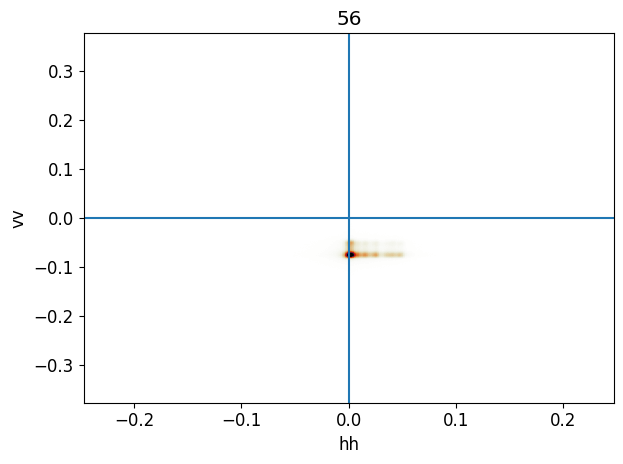

Trial number 100
Trial values: centroid 1.962e-04 fwhm 1.199e-02
Trial dw:
{'_DictionaryWrapper__dictionary': {'h_sigma': 0.3896860590366555, 'h_fwhm': 0.009104214914312792, 'h_centroid': -0.00017546928772624315, 'h_peak': -0.004877257989810118, 'v_sigma': 0.4574281851917597, 'v_fwhm': 0.007803048065651019, 'v_centroid': -8.774229521013588e-05, 'v_peak': 0.08225713169206711, 'integral_intensity': 286.082308198199, 'peak_intensity': 65408.277, 'gaussian_fit': {}}}
Actual fwhm 0.011990591658498573


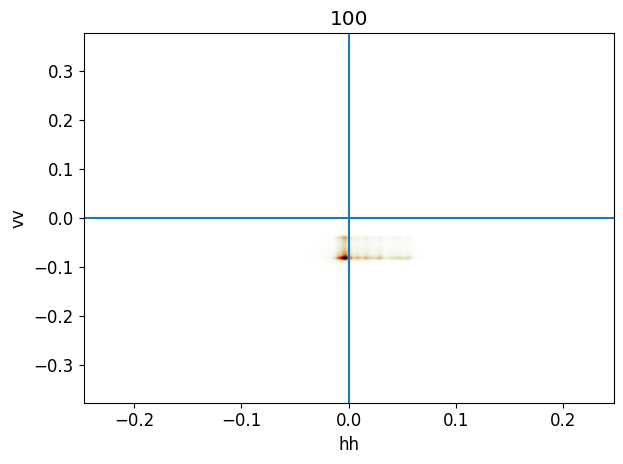

Trial number 105
Trial values: centroid 8.256e-04 fwhm 1.150e-02
Trial dw:
{'_DictionaryWrapper__dictionary': {'h_sigma': 0.3895666052007003, 'h_fwhm': 0.0078036127836966784, 'h_centroid': 0.00037838604609308213, 'h_peak': -0.00032515053265395866, 'v_sigma': 0.4572879366293928, 'v_fwhm': 0.008453302071121938, 'v_centroid': -0.0007337893553190922, 'v_peak': 0.08810941774130515, 'integral_intensity': 286.4684715127203, 'peak_intensity': 65240.55, 'gaussian_fit': {}}}
Actual fwhm 0.011504550768435448


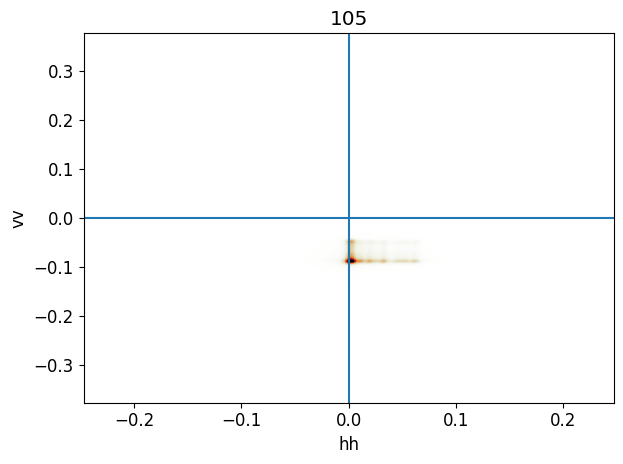

Trial number 109
Trial values: centroid 2.636e-04 fwhm 1.150e-02
Trial dw:
{'_DictionaryWrapper__dictionary': {'h_sigma': 0.3894961090995303, 'h_fwhm': 0.008453913849004735, 'h_centroid': -0.0002517003474366841, 'h_peak': -0.012680870773506308, 'v_sigma': 0.45702302013369284, 'v_fwhm': 0.007803048065651019, 'v_centroid': 7.84121812227867e-05, 'v_peak': 0.0777053536537709, 'integral_intensity': 286.4317739547632, 'peak_intensity': 65324.152, 'gaussian_fit': {}}}
Actual fwhm 0.011504617267917006


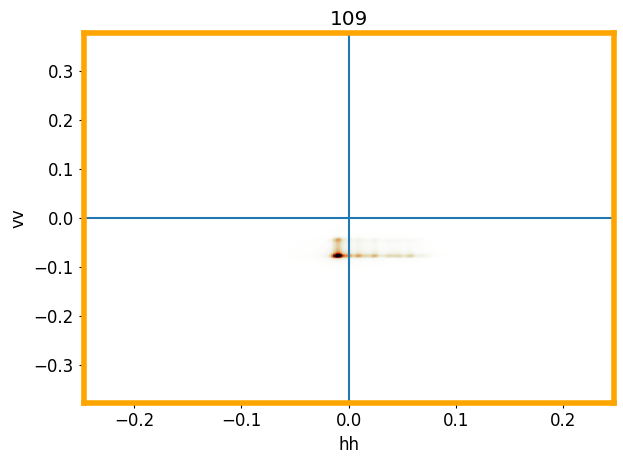

Trial number 112
Trial values: centroid 1.482e-03 fwhm 1.107e-02
Trial dw:
{'_DictionaryWrapper__dictionary': {'h_sigma': 0.38959736652995347, 'h_fwhm': 0.007153311718388622, 'h_centroid': -0.0004947816201363309, 'h_peak': -0.0224353867531264, 'v_sigma': 0.45732763933390963, 'v_fwhm': 0.008453302071121938, 'v_centroid': -0.0013974856960028426, 'v_peak': 0.09656271981242673, 'integral_intensity': 286.3600567507908, 'peak_intensity': 65380.18, 'gaussian_fit': {}}}
Actual fwhm 0.011073761079509997


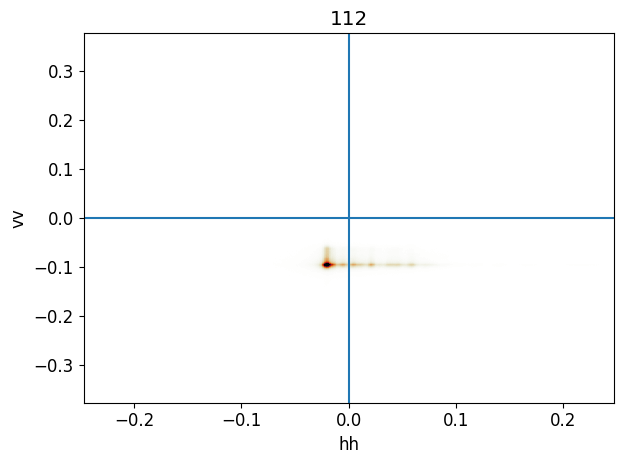

Trial number 150
Trial values: centroid 2.678e-03 fwhm 1.059e-02
Trial dw:
{'_DictionaryWrapper__dictionary': {'h_sigma': 0.38949076413076616, 'h_fwhm': 0.0078036127836966784, 'h_centroid': -0.0011548052835771982, 'h_peak': -0.024386289949050448, 'v_sigma': 0.4573845044652401, 'v_fwhm': 0.007152794060180101, 'v_centroid': -0.0024162143807168746, 'v_peak': 0.11021805392731535, 'integral_intensity': 286.6947189939313, 'peak_intensity': 65365.195, 'gaussian_fit': {}}}
Actual fwhm 0.010585784588079523


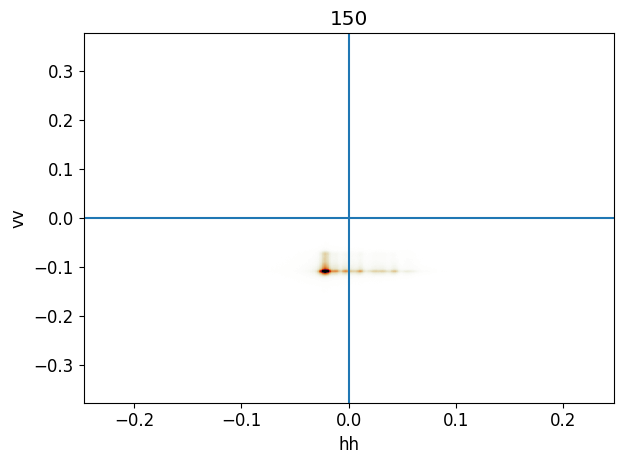

In [21]:
best_hists = []
for t in study.best_trials:
    print("Trial number", t.number)
    print(f"Trial values: centroid {t.values[0]:4.3e} fwhm {t.values[1]:4.3e}")
    print("Trial dw:")
    print(t.user_attrs["dw"].__dict__)
    print("Actual fwhm", opt_common._get_fwhm_from_dw(t.user_attrs["dw"]))
    hist = hists[t.number]
    plt.pcolormesh(hist.hh[700:-700], hist.vv[700:-700], hist.data_2D[700:-700, 700:-700].T, cmap=apu.CMAP)
    if t.number == nash_trial.number:
        for axis in ["top", "bottom", "left", "right"]:
            plt.gca().spines[axis].set_linewidth(4)
            plt.gca().spines[axis].set_color("orange")
    plt.xlabel("hh")
    plt.ylabel("vv")
    plt.axhline(0)
    plt.axvline(0)
    plt.title(t.number)
    plt.tight_layout()
    plt.show()

In [22]:
study.best_trials[0].values

[0.00016740585933942582, 0.014320777831785068]

In [23]:
pareto_df = analysis.get_pareto_dataframe_from_study(study, ["centroid", "fwhm"])

In [24]:
pareto_df

,number,centroid,fwhm,h_peak,v_peak,h_fwhm,v_fwhm,peak_intensity
56,56,0.000167,0.014321,-0.000975,0.075755,0.009104,0.011054,65343.203125
100,100,0.000196,0.011991,-0.004877,0.082257,0.009104,0.007803,65408.277344
105,105,0.000826,0.011505,-0.000325,0.088109,0.007804,0.008453,65240.550781
109,109,0.000264,0.011505,-0.012681,0.077705,0.008454,0.007803,65324.152344
112,112,0.001482,0.011074,-0.022435,0.096563,0.007153,0.008453,65380.179688
150,150,0.002678,0.010586,-0.024386,0.110218,0.007804,0.007153,65365.195312


In [25]:
c1 = [nash_trial.number]
c2 = [t.number for t in study.best_trials if t.number not in c1]
c3 = [n for n in range(len(hists)) if n not in c1 and n not in c2]

In [26]:
c2

[56, 100, 105, 112, 150]

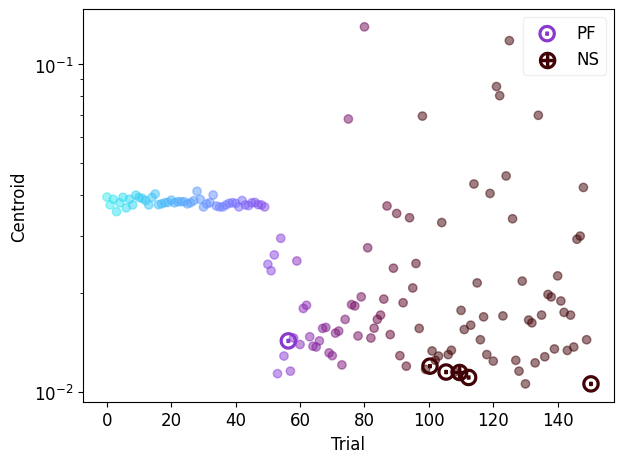

In [29]:
# Plotting the optimization histories
# optuna.visualization.matplotlib.plot_optimization_history(study, target=lambda t: t.values[0], target_name="$f_3$")
# plt.scatter(study.trials.values


plt.figure()
x = np.array([t.number for t in study.trials])
y = np.array([t.values[1] for t in study.trials])

plt.scatter(x[c3], y[c3], c=c3, cmap=cmm.gem_r, marker="o", alpha=0.5, norm=mpl.colors.Normalize(0, 100))
plt.scatter(x[c2], y[c2], c=c2, cmap=cmm.gem_r, marker=r"$\odot$", s=175, norm=mpl.colors.Normalize(0, 100), label="PF")
plt.scatter(
    x[c1], y[c1], c=c1, cmap=cmm.gem_r, marker=r"$\oplus$", s=175, norm=mpl.colors.Normalize(0, 100), label="NS"
)

plt.xlabel("Trial")
plt.ylabel("Centroid")
plt.yscale("log")
# for t in study.best_trials[:-1]:
#    plt.axvline(t.number, color='red', ls=':')
# plt.axvline(study.best_trials[-1].number, color='red', ls=':', label='PT')
# plt.axvline(nash_trial.number, color='orange', label='NS')
plt.legend(loc="best", framealpha=0.3)
plt.tight_layout()
plt.show()

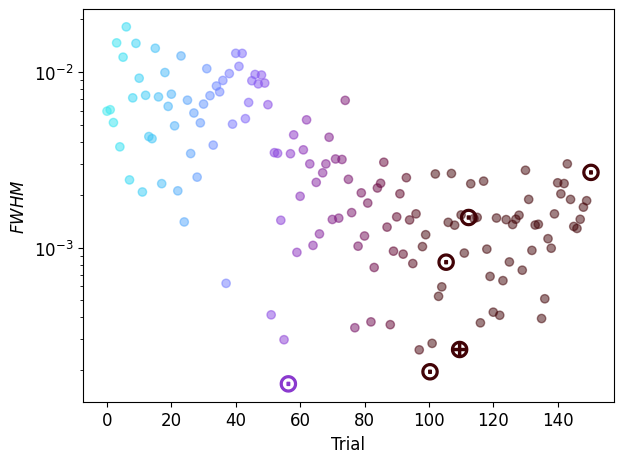

In [30]:
# Plotting the optimization histories
# optuna.visualization.matplotlib.plot_optimization_history(study, target=lambda t: t.values[0], target_name="$f_3$")
# plt.scatter(study.trials.values
plt.figure()
x = np.array([t.number for t in study.trials])
y = np.array([t.values[0] for t in study.trials])

plt.scatter(x[c3], y[c3], c=c3, cmap=cmm.gem_r, marker="o", alpha=0.5, norm=mpl.colors.Normalize(0, 100))
plt.scatter(x[c2], y[c2], c=c2, cmap=cmm.gem_r, marker=r"$\odot$", s=175, norm=mpl.colors.Normalize(0, 100), label="PF")
plt.scatter(
    x[c1], y[c1], c=c1, cmap=cmm.gem_r, marker=r"$\oplus$", s=175, norm=mpl.colors.Normalize(0, 100), label="NS"
)

plt.xlabel("Trial")
plt.ylabel("$FWHM$")
plt.yscale("log")
# for t in study.best_trials[:-1]:
#    plt.axvline(t.number, color='red', ls=':')
# plt.axvline(study.best_trials[-1].number, color='red', ls=':', label='PT')
# plt.axvline(nash_trial.number, color='orange', label='NS')
plt.tight_layout()
plt.show()

In [31]:
ntrials = len(study.trials)

/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_4178/415779797.py:36: MatplotlibDeprecationWarning: The execute_constrained_layout function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use figure.get_layout_engine().execute() instead.
  fig.execute_constrained_layout()


4.460711181393228 4.372882222222223


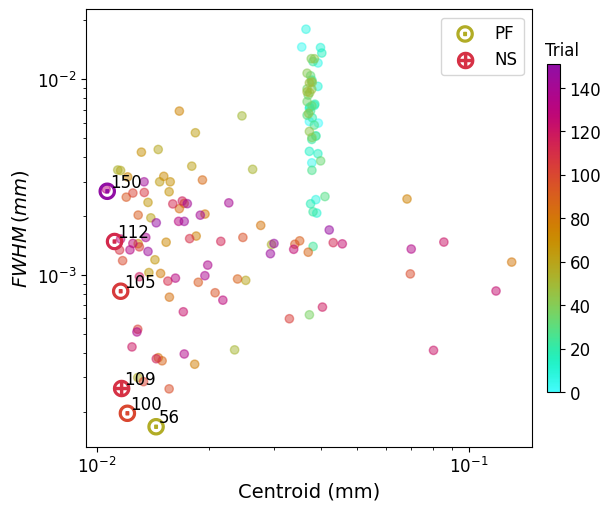

In [32]:
x = np.array([t.values[1] for t in study.trials])
y = np.array([t.values[0] for t in study.trials])

fig = plt.figure(figsize=[6, 5], constrained_layout=True)
plt.scatter(x[c3], y[c3], c=c3, cmap=cmm.tropical_r, marker="o", alpha=0.5, norm=mpl.colors.Normalize(0, ntrials))
plt.scatter(
    x[c2], y[c2], c=c2, cmap=cmm.tropical_r, marker=r"$\odot$", s=175, norm=mpl.colors.Normalize(0, ntrials), label="PF"
)
plt.scatter(
    x[c1],
    y[c1],
    c=c1,
    cmap=cmm.tropical_r,
    marker=r"$\oplus$",
    s=175,
    norm=mpl.colors.Normalize(0, ntrials),
    label="NS",
)

for t in study.best_trials:
    plt.annotate(t.number, xy=(x[t.number], y[t.number]), xytext=(3, 3), textcoords="offset points")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Centroid (mm)", fontsize=14)
plt.ylabel("$FWHM\,(mm)$", fontsize=14)
cbar = plt.colorbar(pad=0.03, aspect=25, shrink=0.75, location="right")
# cbar.ax.set_ylabel('Trial')
cbar.ax.text(-0.1, 155.0, "Trial")
# cbar.ax.set_xlabel('Trial')#, fontsize=14)

# plt.scatter(ground['fwhm'], ground['peak_distance'], color='red', marker='*', s=175, label='M')
plt.legend(loc="best")
r = fig.canvas.get_renderer()
ax = plt.gca()

fig.execute_constrained_layout()
print(ax.bbox.width / fig.dpi, ax.bbox.height / fig.dpi)
#plt.savefig(f"{out_dir}/pareto_fwhm_pl.svg", bbox_inches="tight", dpi=600)
plt.show()

### Combining the figures into one

In [21]:
import matplotlib.gridspec as gridspec

In [22]:
props = apu.AnalyzedProps(study, nash_trial, max_count=np.inf, min_count=200, xylim=0.25, photon_count_str="3.1e")

In [23]:
out_dir

PosixPath('/Users/skandel/Library/CloudStorage/Box-Box/autofocus_paper/figures/centroid_fwhm')

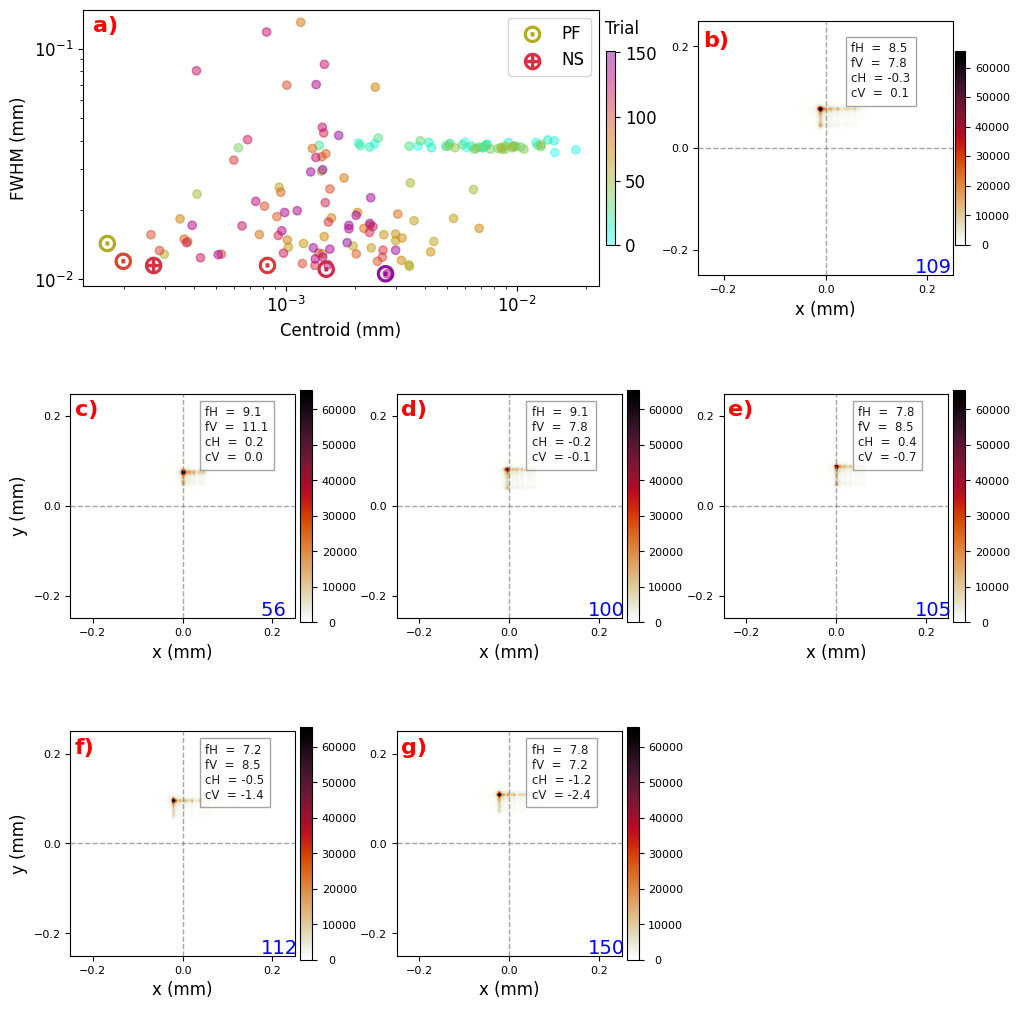

In [24]:
fig = plt.figure(figsize=[10, 10], layout="constrained")
gs0 = gridspec.GridSpec(2, 1, figure=fig, height_ratios=[0.33, 0.67])

# top row
gss0 = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs0[0], width_ratios=[0.67, 0.33])
axs00 = fig.add_subplot(gss0[0])

cscatter, sublabel = apu.plot_pareto_2d(
    props, axs00, "Centroid", "FWHM", sublabel='a', annotate=False, legend=True, legend_loc="upper right", fontsize=12
)

cbar = plt.colorbar(cscatter, ax=axs00, pad=0.01, shrink=0.7, location="right")
cbar.ax.text(-0.1, 165, "Trial")

axs01 = fig.add_subplot(gss0[1])

cmesh1, sublabel = apu.plot_hist_2d(props, axs01, hists[nash_trial.number], study_num=nash_trial.number, sublabel=sublabel)

text = (
            rf"{'fH':<3} = {dwds[nash_trial.number]['h_fwhm'] * 1000: 3.1f}" + "\n"
            rf"{'fV':<3} = {dwds[nash_trial.number]['v_fwhm']* 1000: 3.1f}" + "\n"
            rf"{'cH':<3} = {dwds[nash_trial.number]['h_centroid']* 1000: 3.1f}" + "\n"
            rf"{'cV':<3} = {dwds[nash_trial.number]['v_centroid']* 1000: 3.1f}"
        )
text = text.replace("e+", "e")
apu.add_text_to_hist(props, axs01, study.trials[nash_trial.number].user_attrs["dw"], fontsize=8.5, text=text)

cbar = plt.colorbar(cmesh1, ax=axs01, pad=0.01, shrink=0.7, format='%3.0f')
cbar.ax.tick_params(labelsize=8)

axs01.locator_params(nbins=4)

gss1 = gridspec.GridSpecFromSubplotSpec(2, 3, subplot_spec=gs0[1])
axs1 = gss1.subplots()
axs1 = axs1.flatten()
for ax in axs1:
    ax.set_visible(False)


rest_trials = [t for t in study.best_trials if t.number != nash_trial.number]
for ix, t in enumerate(rest_trials):
    n = t.number
    axs1[ix].set_visible(True)

    ylabel = False
    if ix % 3 == 0: 
        ylabel = True
    cmesh, sublabel = apu.plot_hist_2d(props, axs1[ix], hists[n], study_num=n, sublabel=sublabel, ylabel=ylabel)

    text = (
            rf"{'fH':<3} = {dwds[n]['h_fwhm'] * 1000: 3.1f}" + "\n"
            rf"{'fV':<3} = {dwds[n]['v_fwhm']* 1000: 3.1f}" + "\n"
            rf"{'cH':<3} = {dwds[n]['h_centroid']* 1000: 3.1f}" + "\n"
            rf"{'cV':<3} = {dwds[n]['v_centroid']* 1000: 3.1f}"
        )
    text = text.replace("e+", "e")
    apu.add_text_to_hist(props, axs1[ix], t.user_attrs["dw"], fontsize=8.5, text=text)

    cbar = fig.colorbar(cmesh, ax=axs1[ix], pad=0.01, shrink=0.7, format='%3.0f')
    cbar.ax.tick_params(labelsize=8)

    axs1[ix].locator_params(nbins=4)


fig.get_layout_engine().set(w_pad=0, h_pad=0, hspace=0.01, wspace=0.01)
plt.savefig(f"{out_dir}/fig_combined.pdf", bbox_inches="tight", dpi=600)
plt.savefig(f"{out_dir}/fig_combined.png", bbox_inches="tight", dpi=600)
plt.show()